In [1]:
%load_ext autoreload
%autoreload complete
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from protest_impact.util import cache, project_root
from tqdm.notebook import tqdm

## Tutorial

In [2]:
import dowhy.datasets
from dowhy import CausalModel

# Generate some sample data
data = dowhy.datasets.linear_dataset(
    beta=10, num_common_causes=5, num_instruments=2, num_samples=10000
)
data

{'df':        Z0        Z1        W0        W1        W2        W3        W4     v0  \
 0     0.0  0.299320  0.169849  0.150226  1.168620 -0.373204 -0.338041   True   
 1     0.0  0.328271 -1.577853  0.311730 -0.515850 -1.664690 -0.809543  False   
 2     1.0  0.701568  3.464803 -0.083640  0.246139 -0.386201  0.867479   True   
 3     0.0  0.262474  2.042332 -1.499504 -0.707841 -1.543139 -0.549024  False   
 4     1.0  0.665006 -0.902401  0.009154 -0.352799 -0.685141  0.802383   True   
 ...   ...       ...       ...       ...       ...       ...       ...    ...   
 9995  0.0  0.519132 -0.228580  1.166291 -0.768169 -1.992574  0.573426   True   
 9996  1.0  0.251953  1.070773  1.169905  0.001952 -1.423200  0.214875   True   
 9997  0.0  0.459571 -0.427083 -0.034942  0.030174 -0.285005  1.553392   True   
 9998  0.0  0.147923  2.216488 -1.131471 -1.311781 -1.676119 -0.704631  False   
 9999  0.0  0.032049  0.553324 -1.685882  0.243375 -0.005859  1.026997   True   
 
               y  
 

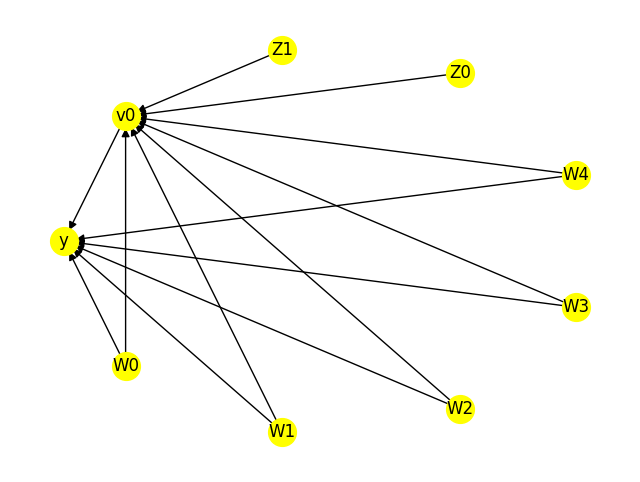

In [3]:
# Step 1: Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"],
)
model.view_model()

In [4]:
# Step 2: Identify causal effect and return target estimands
identified_estimand = model.identify_effect()
identified_estimand.estimands

{'backdoor1': {'estimand': Derivative(Expectation(y|W4,Z0,W2,Z1,W0,W3,W1), [v0]),
  'assumptions': {'Unconfoundedness': 'If U→{v0} and U→y then P(y|v0,W4,Z0,W2,Z1,W0,W3,W1,U) = P(y|v0,W4,Z0,W2,Z1,W0,W3,W1)'}},
 'backdoor2': {'estimand': Derivative(Expectation(y|W4,W2,W0,W3,W1), [v0]),
  'assumptions': {'Unconfoundedness': 'If U→{v0} and U→y then P(y|v0,W4,W2,W0,W3,W1,U) = P(y|v0,W4,W2,W0,W3,W1)'}},
 'backdoor': {'estimand': Derivative(Expectation(y|W4,W2,W0,W3,W1), [v0]),
  'assumptions': {'Unconfoundedness': 'If U→{v0} and U→y then P(y|v0,W4,W2,W0,W3,W1,U) = P(y|v0,W4,W2,W0,W3,W1)'}},
 'iv': {'estimand': Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1)),
  'assumptions': {'As-if-random': 'If U→→y then ¬(U →→{Z0,Z1})',
   'Exclusion': 'If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)'}},
 'frontdoor': None}

In [5]:
# Step 3: Estimate the target estimand using a statistical method.
estimate = model.estimate_effect(
    identified_estimand, method_name="backdoor.propensity_score_matching"
)
estimate.value

In [ ]:
# Step 4: Refute the obtained estimate using multiple robustness checks.
# refute_results = model.refute_estimate(
#     identified_estimand, estimate, method_name="random_common_cause"
# )
# refute_results

## Protest impacts

In [51]:
%%capture

df = pd.read_csv(project_root / "data" / "daily_data.csv")
df["protest"] = (df["count_moderate"] > 0) | (df["count_radical"] > 0)

# add lags to all columns (taking into account the region)
df = df.sort_values(["region", "date"])
for col in df.columns:
    if col in ["date", "region", "weekday"] or col.startswith("instr_"):
        continue
    for i in range(1, 3):
        df[f"{col}_lag_{i}"] = df.groupby("region")[col].shift(i)

In [54]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

df.isna().sum().to_frame()

,0
date,0
region,0
size_radical,0
size_moderate,0
count_radical,0
count_moderate,0
climate_and_protest_mediacloud,0
climate_not_protest_mediacloud,0
climate_mediacloud,0
instr_prcp,0


In [53]:
# drop the first 7 days
print(df.shape)
df = df.dropna(subset=["protest_lag_2"])
print(df.shape)

(15344, 68)
(15316, 68)


In [55]:
pd.set_option("display.max_columns", 100)
df.head()

,date,region,size_radical,size_moderate,count_radical,count_moderate,climate_and_protest_mediacloud,climate_not_protest_mediacloud,climate_mediacloud,instr_prcp,instr_pres,instr_snow,instr_tavg,instr_tmax,instr_tmin,instr_tsun,instr_wdir,instr_wpgt,instr_wspd,instr_longterm_prcp,instr_longterm_pres,instr_longterm_snow,instr_longterm_tavg,instr_longterm_tmax,instr_longterm_tmin,instr_longterm_tsun,instr_longterm_wdir,instr_longterm_wpgt,instr_longterm_wspd,instr_retail_and_recreation,instr_grocery_and_pharmacy,instr_residential,instr_transit_stations,instr_parks,instr_workplaces,weekday,is_holiday,size_moderate_official,size_radical_official,count_moderate_official,count_radical_official,protest,size_radical_lag_1,size_radical_lag_2,size_moderate_lag_1,size_moderate_lag_2,count_radical_lag_1,count_radical_lag_2,count_moderate_lag_1,count_moderate_lag_2,climate_and_protest_mediacloud_lag_1,climate_and_protest_mediacloud_lag_2,climate_not_protest_mediacloud_lag_1,climate_not_protest_mediacloud_lag_2,climate_mediacloud_lag_1,climate_mediacloud_lag_2,is_holiday_lag_1,is_holiday_lag_2,size_moderate_official_lag_1,size_moderate_official_lag_2,size_radical_official_lag_1,size_radical_official_lag_2,count_moderate_official_lag_1,count_moderate_official_lag_2,count_radical_official_lag_1,count_radical_official_lag_2,protest_lag_1,protest_lag_2
31,2020-01-03,Bayern,0.0,0.0,0.0,0.0,17,44,61,1.9,1027.0,0.0,3.5,8.4,-4.2,251.0,236.0,41.0,10.4,4.58,1022.12,12.0,1.41,4.88,-0.95,125.4,226.521154,41.397308,11.294808,0.0,0.0,0.0,0.0,0.0,0.0,Friday,False,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,1.0,52.0,21.0,68.0,22.0,False,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
45,2020-01-04,Bayern,0.0,0.0,0.0,0.0,5,17,22,0.8,1029.9,0.0,4.3,7.0,2.8,0.0,272.0,46.1,18.0,5.45,1018.04,11.0,1.86,4.55,-0.53,74.4,212.580000,45.198000,15.004000,0.0,0.0,0.0,0.0,0.0,0.0,Saturday,False,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,16.0,44.0,52.0,61.0,68.0,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
59,2020-01-05,Bayern,0.0,0.0,0.0,0.0,2,17,19,0.0,1036.0,0.0,2.5,4.7,-1.3,24.0,273.0,43.2,10.1,4.77,1015.73,16.0,1.61,4.32,-1.10,87.0,226.060000,47.014000,14.796000,0.0,0.0,0.0,0.0,0.0,0.0,Sunday,False,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,17.0,17.0,44.0,22.0,61.0,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
73,2020-01-06,Bayern,0.0,0.0,0.0,0.0,7,52,59,0.0,1030.5,0.0,0.8,6.0,-2.5,491.0,154.0,20.5,5.8,1.49,1018.02,20.0,1.30,4.43,-1.84,148.8,198.900000,30.068000,10.156000,0.0,0.0,0.0,0.0,0.0,0.0,Monday,True,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,17.0,17.0,19.0,22.0,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
87,2020-01-07,Bayern,0.0,0.0,0.0,0.0,11,64,75,1.6,1030.2,0.0,2.4,4.6,-2.1,3.0,252.0,39.2,8.3,2.54,1020.93,15.0,2.42,5.15,-0.34,88.8,185.720000,33.814000,10.494000,0.0,0.0,0.0,0.0,0.0,0.0,Tuesday,False,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,52.0,17.0,59.0,19.0,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False


In [56]:
# import networkx as nx

# causal_graph = nx.DiGraph()
# for i in range(1, 8):
#     causal_graph.add_edge(f"size_radical_{i}", f"climate_and_protest_mediacloud_{i}")
#     causal_graph.add_edge(f"size_radical_{i}", f"climate_not_protest_mediacloud_{i}")
#     causal_graph.add_edge(f"size_moderate_{i}", f"climate_and_protest_mediacloud_{i}")
#     causal_graph.add_edge(f"size_moderate_{i}", f"climate_not_protest_mediacloud_{i}")
#     causal_graph.add_edge(f"pres_{i}", f"size_radical_{i}")
#     causal_graph.add_edge(f"pres_{i}", f"size_moderate_{i}")
#     causal_graph.add_edge(f"stringency_index_{i}", f"size_radical_{i}")
#     causal_graph.add_edge(f"stringency_index_{i}", f"size_moderate_{i}")
#     causal_graph.add_edge(f"size_radical_{i}", f"size_radical_{i+1}")
#     causal_graph.add_edge(f"size_moderate_{i}", f"size_moderate_{i+1}")
#     causal_graph.add_edge(f"pres_{i}", f"pres_{i+1}")
#     causal_graph.add_edge(f"stringency_index_{i}", f"stringency_index_{i+1}")
#     causal_graph.add_edge(
#         f"climate_and_protest_mediacloud_{i}", f"climate_and_protest_mediacloud_{i+1}"
#     )
#     causal_graph.add_edge(
#         f"climate_not_protest_mediacloud_{i}", f"climate_not_protest_mediacloud_{i+1}"
#     )
#     causal_graph.add_edge(f"size_radical_{i}", f"climate_and_protest_mediacloud_{i+1}")
#     causal_graph.add_edge(f"size_radical_{i}", f"climate_not_protest_mediacloud_{i+1}")
#     causal_graph.add_edge(f"size_moderate_{i}", f"climate_and_protest_mediacloud_{i+1}")
#     causal_graph.add_edge(f"size_moderate_{i}", f"climate_not_protest_mediacloud_{i+1}")

# # nx.write_gexf(causal_graph, "test.gexf")
# graph_string = nx.generate_gml(causal_graph)
# graph_string = "\n".join(graph_string)

In [57]:
# simpler model: connect all columns to the treatment (size_radical)

# import networkx as nx

# causal_graph = nx.DiGraph()
# for col in df.columns:
#     if col in ["date", "region", "weekday"]:
#         continue
#     if col not in [
#         "size_moderate",
#         "size_radical",
#         "climate_and_protest_mediacloud",
#         "climate_not_protest_mediacloud",
#         "protest",
#     ]:
#         causal_graph.add_edge(col, "protest")
#         causal_graph.add_edge(col, "protest")
#         causal_graph.add_edge(col, "climate_and_protest_mediacloud")
#         causal_graph.add_edge(col, "climate_not_protest_mediacloud")
# causal_graph.add_edge(f"protest", "climate_and_protest_mediacloud")
# causal_graph.add_edge(f"protest", "climate_not_protest_mediacloud")

# graph_string = nx.generate_gml(causal_graph)
# graph_string = "\n".join(graph_string)

In [58]:
df.columns

Index(['date', 'region', 'size_radical', 'size_moderate', 'count_radical',
       'count_moderate', 'climate_and_protest_mediacloud',
       'climate_not_protest_mediacloud', 'climate_mediacloud', 'instr_prcp',
       'instr_pres', 'instr_snow', 'instr_tavg', 'instr_tmax', 'instr_tmin',
       'instr_tsun', 'instr_wdir', 'instr_wpgt', 'instr_wspd',
       'instr_longterm_prcp', 'instr_longterm_pres', 'instr_longterm_snow',
       'instr_longterm_tavg', 'instr_longterm_tmax', 'instr_longterm_tmin',
       'instr_longterm_tsun', 'instr_longterm_wdir', 'instr_longterm_wpgt',
       'instr_longterm_wspd', 'instr_retail_and_recreation',
       'instr_grocery_and_pharmacy', 'instr_residential',
       'instr_transit_stations', 'instr_parks', 'instr_workplaces', 'weekday',
       'is_holiday', 'size_moderate_official', 'size_radical_official',
       'count_moderate_official', 'count_radical_official', 'protest',
       'size_radical_lag_1', 'size_radical_lag_2', 'size_moderate_lag_1',
      

In [75]:
# simpler model: without time series

import networkx as nx

causal_graph = nx.DiGraph()
# causal_graph.add_edge("protest", "climate_and_protest_mediacloud")
# causal_graph.add_edge("protest", "climate_not_protest_mediacloud")
# causal_graph.add_edge("protest", "size_moderate")
# causal_graph.add_edge("protest", "size_radical")
# causal_graph.add_edge("protest", "count_moderate")
# causal_graph.add_edge("protest", "count_radical")

protest_vars = [
    "protest"
]  # , "size_moderate", "size_radical", "count_moderate", "count_radical"]
media_vars = ["climate_and_protest_mediacloud", "climate_not_protest_mediacloud"]
lagged_media_vars = [
    "climate_and_protest_mediacloud_lag_1",
    "climate_not_protest_mediacloud_lag_1",
]
other_confounders = ["weekday", "is_holiday"]
instruments = ["instr_prcp", "instr_pres", "instr_residential"]

for protest_var in protest_vars:
    for media_var in media_vars:
        causal_graph.add_edge(protest_var, media_var)

for lagged_media_var in lagged_media_vars:
    for media_var in media_vars:
        causal_graph.add_edge(lagged_media_var, media_var)
    for protest_var in protest_vars:
        causal_graph.add_edge(lagged_media_var, protest_var)
for other_confounder in other_confounders:
    for protest_var in protest_vars:
        causal_graph.add_edge(other_confounder, protest_var)
    for media_var in media_vars:
        causal_graph.add_edge(other_confounder, media_var)

for instrument in instruments:
    causal_graph.add_edge(instrument, "protest")

graph_string = nx.generate_gml(causal_graph)
graph_string = "\n".join(graph_string)

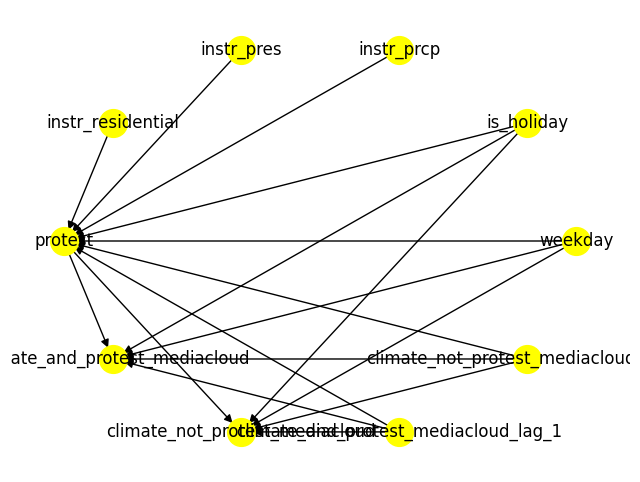

In [76]:
model = CausalModel(
    data=df,
    treatment="protest",
    outcome="climate_and_protest_mediacloud",
    graph=graph_string,
)
model.view_model(layout="circo")

In [77]:
from pprint import pprint

identified_estimand = model.identify_effect()
pprint(identified_estimand.estimands)

{'backdoor': {'assumptions': {'Unconfoundedness': 'If U→{protest} and '
                                                  'U→climate_and_protest_mediacloud '
                                                  'then '
                                                  'P(climate_and_protest_mediacloud|protest,climate_and_protest_mediacloud_lag_1,is_holiday,weekday,climate_not_protest_mediacloud_lag_1,U) '
                                                  '= '
                                                  'P(climate_and_protest_mediacloud|protest,climate_and_protest_mediacloud_lag_1,is_holiday,weekday,climate_not_protest_mediacloud_lag_1)'},
              'estimand': Derivative(Expectation(climate_and_protest_mediacloud|climate_and_protest_mediacloud_lag_1,is_holiday,weekday,climate_not_protest_mediacloud_lag_1), [protest])},
 'backdoor1': {'assumptions': {'Unconfoundedness': 'If U→{protest} and '
                                                   'U→climate_and_protest_mediacloud '
  

### IV

In [83]:
estimate = model.estimate_effect(
    identified_estimand, method_name="iv.instrumental_variable"
)

In [88]:
print(estimate.get_confidence_intervals(0.95))

(226.4308379235203, 268.74312147364515)


In [90]:
refuters = [
    "random_common_cause",
    "placebo_treatment_refuter",
    "data_subset_refuter",
    "bootstrap_refuter",
]
for refuter in refuters:
    refute_results = model.refute_estimate(
        identified_estimand, estimate, method_name="random_common_cause"
    )
    print(refuter)
    print(refute_results)

random_common_cause
Refute: Add a random common cause
Estimated effect:244.1273593573137
New effect:244.12735935731368
p value:2.0


---

placebo_treatment_refuter
Refute: Add a random common cause
Estimated effect:244.1273593573137
New effect:244.12735935731368
p value:2.0


---

data_subset_refuter
Refute: Add a random common cause
Estimated effect:244.1273593573137
New effect:244.12735935731368
p value:2.0


---

bootstrap_refuter
Refute: Add a random common cause
Estimated effect:244.1273593573137
New effect:244.12735935731368
p value:2.0


---



### Propensity score

In [102]:
estimate = model.estimate_effect(
    identified_estimand, method_name="backdoor.linear_regression"
)
estimate.value, estimate.get_confidence_intervals(
    0.95
), estimate.test_stat_significance()

(6.697823935335068,
 array([[5.95447028, 7.44117759]]),
 {'p_value': array([4.04198629e-69])})

In [101]:
refuters = [
    "random_common_cause",
    "placebo_treatment_refuter",
    "data_subset_refuter",
    "bootstrap_refuter",
]

for refuter in refuters:
    refute_results = model.refute_estimate(
        identified_estimand, estimate, method_name="random_common_cause"
    )
    print(refuter)
    print(refute_results)

random_common_cause
Refute: Add a random common cause
Estimated effect:6.697823935335068
New effect:6.698038024623579
p value:1.0

placebo_treatment_refuter
Refute: Add a random common cause
Estimated effect:6.697823935335068
New effect:6.697679677502674
p value:0.96

data_subset_refuter
Refute: Add a random common cause
Estimated effect:6.697823935335068
New effect:6.698290428569947
p value:0.88

bootstrap_refuter
Refute: Add a random common cause
Estimated effect:6.697823935335068
New effect:6.6975452240262845
p value:0.96



In [107]:
estimate = model.estimate_effect(
    identified_estimand, method_name="backdoor.distance_matching"
)
estimate.value

In [108]:
estimate = model.estimate_effect(
    identified_estimand, method_name="backdoor.propensity_score_matching"
)
estimate.value

^ different than above, lol.

In [110]:
estimate = model.estimate_effect(
    identified_estimand, method_name="backdoor.propensity_score_stratification"
)
estimate.value

In [112]:
estimate = model.estimate_effect(
    identified_estimand, method_name="backdoor.propensity_score_weighting"
)
estimate.value